In [1]:
# Main library: https://square.github.io/pysurvival/index.html
#----------------------------Reproducible------------------------------------------
import numpy as np
import random as rn
import pandas as pd
import gc
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
rn.seed(seed)

#----------------------------Reproducible------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.model_selection import train_test_split
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.display import display_loss_values
from pysurvival.utils.display import compare_to_actual

from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt

import heapq
import seaborn as sns

In [2]:
def csv_read(p_path):
    pd_data=pd.read_csv(p_path, sep=',')
    column_names=pd_data.columns.values.tolist()
    print(column_names)
    return pd_data,column_names

def write_to_csv(p_data,p_path):
    dataframe = pd.DataFrame(p_data)
    dataframe.to_csv(p_path, mode='a',header=False,index=False,sep=',')
    del dataframe
    gc.collect()

In [3]:
data,column_names=csv_read('./data/survival_data_filtered_3.csv')

['NACCREAS', 'NACCREFR', 'BIRTHMO', 'BIRTHYR', 'SEX', 'HISPANIC', 'HISPOR', 'RACE', 'RACESEC', 'RACETER', 'PRIMLANG', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'INBIRMO', 'INBIRYR', 'INSEX', 'NACCNINR', 'INRELTO', 'INLIVWTH', 'INVISITS', 'INCALLS', 'INRELY', 'NACCFAM', 'NACCMOM', 'NACCDAD', 'NACCFADM', 'NACCFFTD', 'ANYMEDS', 'DRUG1', 'NACCSTYR', 'NACCTIYR', 'MEMORY', 'ORIENT', 'JUDGMENT', 'COMMUN', 'HOMEHOBB', 'PERSCARE', 'CDRSUM', 'COMPORT', 'CDRLANG', 'NPIQINF', 'DEL', 'DELSEV', 'HALL', 'HALLSEV', 'AGIT', 'AGITSEV', 'DEPD', 'DEPDSEV', 'ANX', 'ANXSEV', 'ELAT', 'ELATSEV', 'APA', 'APASEV', 'DISN', 'DISNSEV', 'IRR', 'IRRSEV', 'MOT', 'MOTSEV', 'NITE', 'NITESEV', 'APP', 'APPSEV', 'BILLS', 'TAXES', 'SHOPPING', 'GAMES', 'STOVE', 'MEALPREP', 'EVENTS', 'PAYATTN', 'REMDATES', 'TRAVEL', 'DECSUB', 'DECIN', 'COGMEM', 'COGJUDG', 'COGLANG', 'COGVIS', 'COGATTN', 'COGFLUC', 'COGOTHR', 'NACCCOGF', 'COGMODE', 'DECAGE', 'BEAPATHY', 'BEDEP', 'BEVHALL', 'BEAHALL', 'BEDEL', 'BEDISIN'

In [4]:
data

,NACCREAS,NACCREFR,BIRTHMO,BIRTHYR,SEX,HISPANIC,HISPOR,RACE,RACESEC,RACETER,...,NPBNKB,NACCFORM,NACCPARA,NACCCSFP,NPBNKF,NPFAUT,NACCDAGE,NACCINT,SurvivalTime,Event
0,2,2,10,1946,2,0,88,1,88,88,...,1,1,1,0,0,0,72,33,891,True
1,1,8,5,1931,1,0,88,1,88,88,...,0,1,1,0,0,0,88,43,1304,True
2,2,2,1,1924,2,0,88,1,88,88,...,1,1,1,0,0,0,90,67,702,True
3,1,2,9,1934,2,0,88,1,88,88,...,1,1,1,1,1,0,84,4,379,True
4,1,8,10,1942,2,0,88,1,88,88,...,0,1,1,1,0,0,76,53,1099,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,1,1,11,1938,2,0,88,1,88,88,...,1,1,1,0,0,0,76,2,2733,True
348,1,1,5,1951,1,0,88,1,88,88,...,0,1,1,1,0,0,68,36,2539,False
349,1,2,5,1954,2,0,88,1,88,88,...,1,1,1,0,0,0,66,91,1127,False
350,2,2,7,1924,2,0,88,1,3,88,...,1,1,1,0,0,0,96,3,417,True


In [5]:
Events=np.array(data.loc[:,'Event'])
print("%.2f%% samples are right censored in whole data." % (np.sum(~Events) * 100. / len(Events)))

38.92% samples are right censored in whole data.


In [ ]:
X=data.loc[:,'NACCREAS':'NACCINT']
y_=data.loc[:,'SurvivalTime':'Event']
y=np.array([(y__[1],y__[0]) for y__ in np.array(y_)], dtype=[('Event', 'bool'), ('SurvivalTime', '<f8')])

models=[]
structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]
seed_num=15
epoch_num=2000

for seed_i in np.arange(seed_num):

    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=seed_i)

    time_train=y_train['SurvivalTime']
    event_train=y_train['Event']
    time_test=y_test['SurvivalTime']
    event_test=y_test['Event']

    # Building the model
    nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
    nonlinear_coxph.fit(X_train, time_train, event_train, num_epochs = epoch_num,lr=1e-4, init_method='glorot_uniform')

    models.append(nonlinear_coxph)

% Completion: 100%|***********************************************|Loss: 452.38


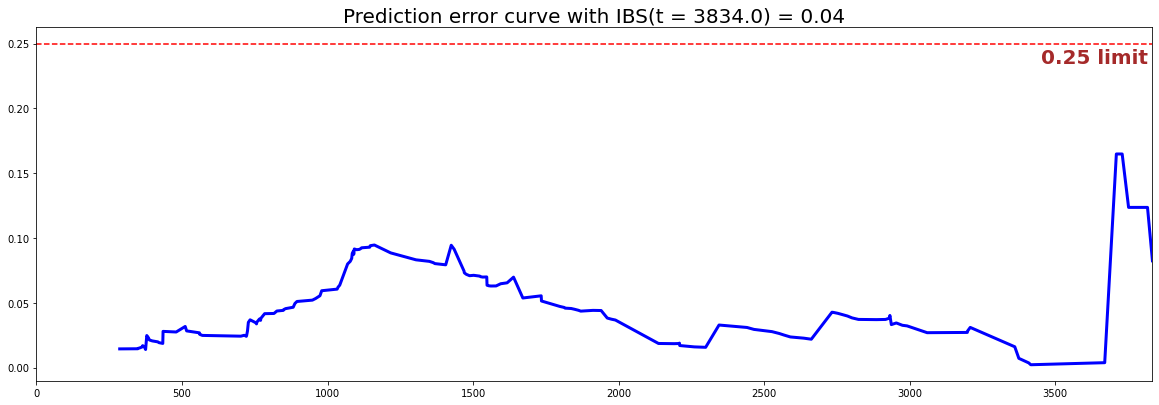

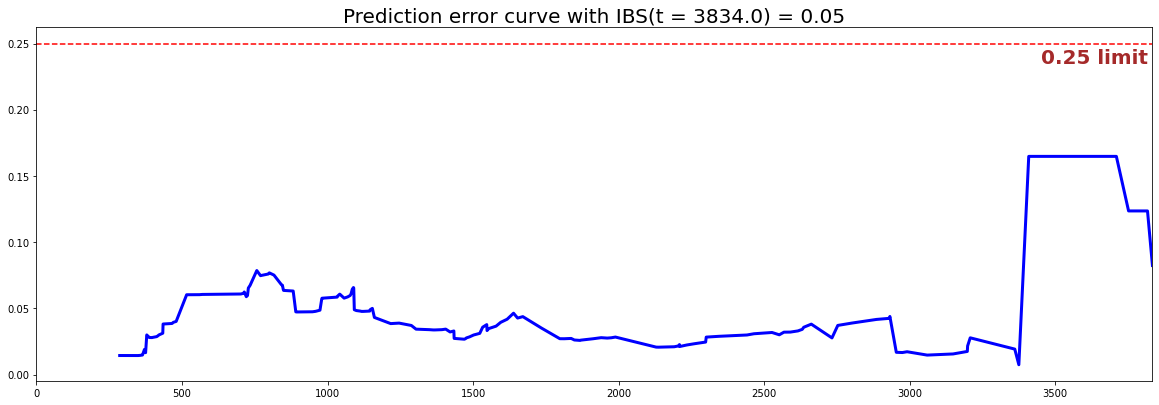

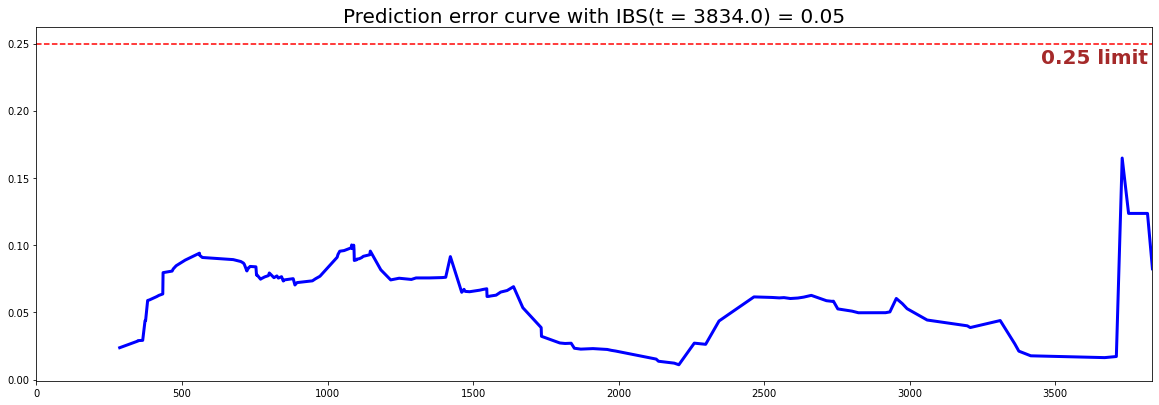

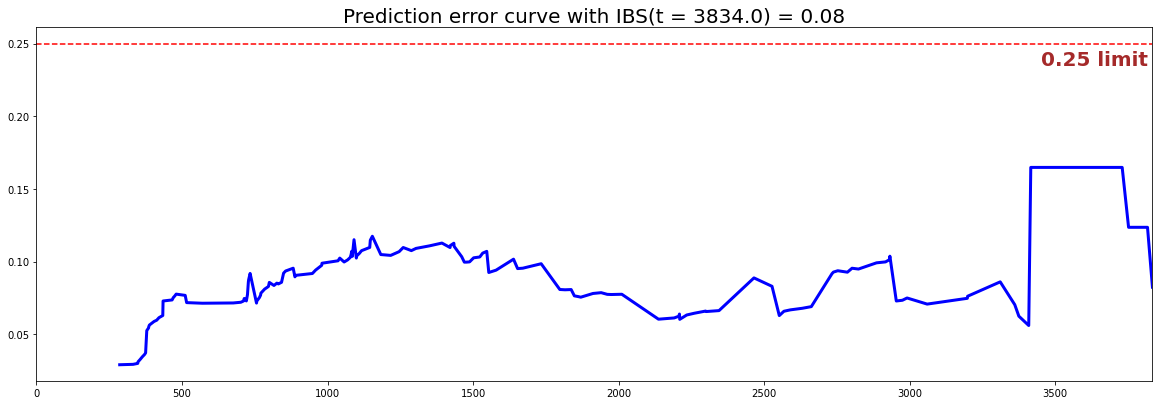

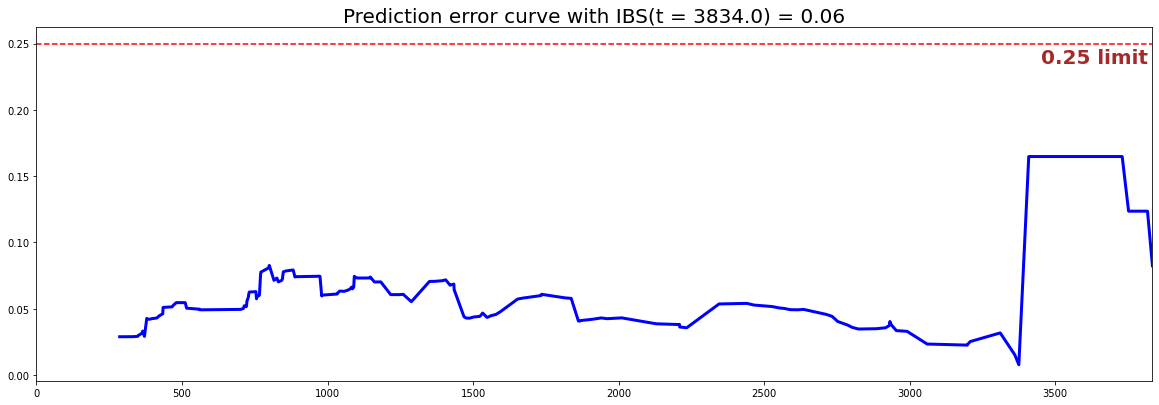

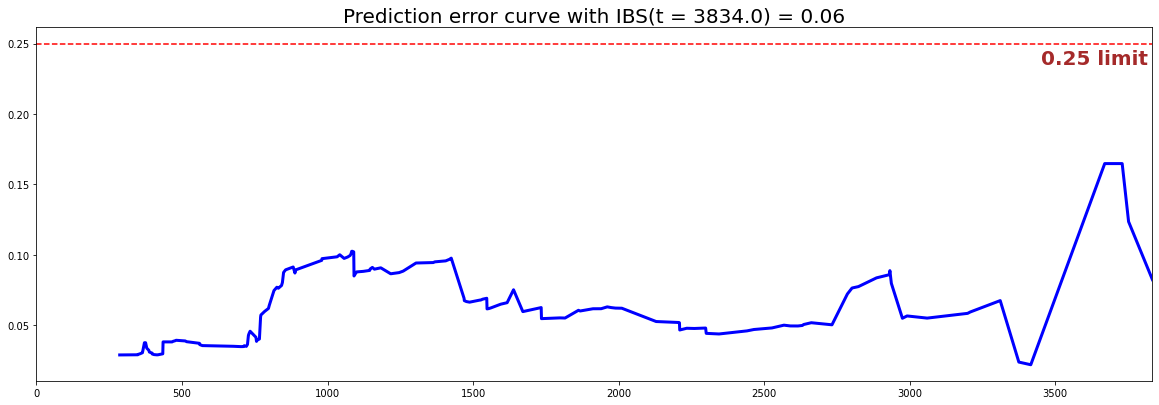

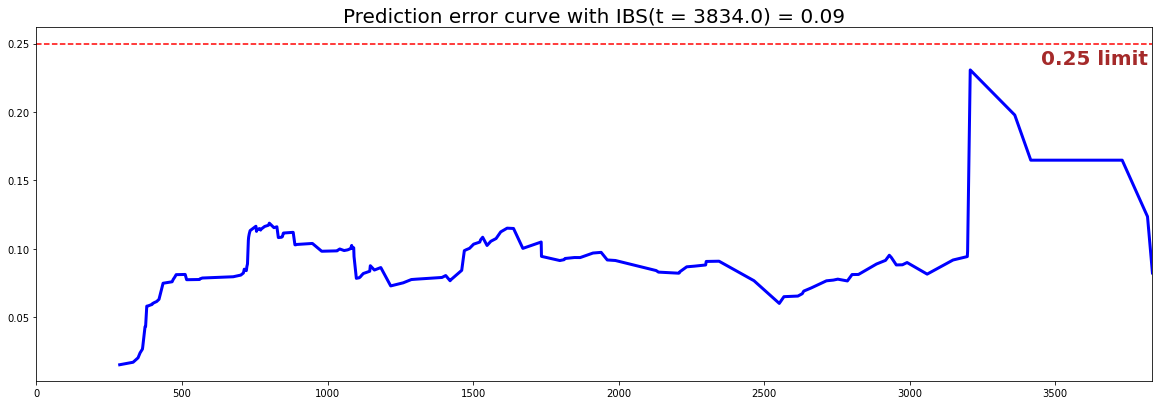

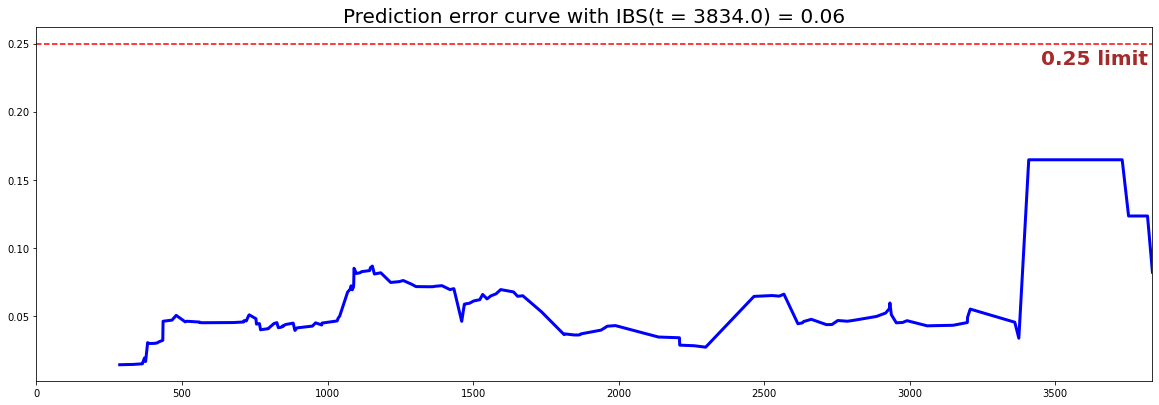

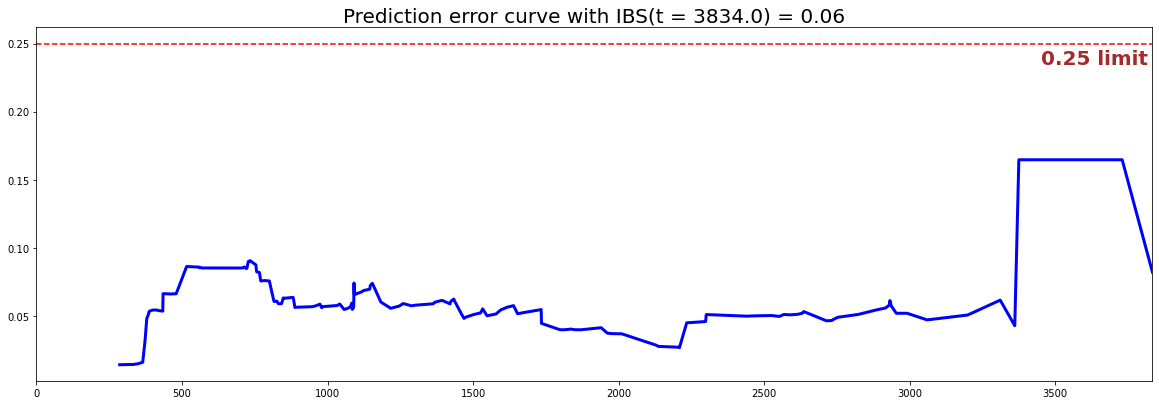

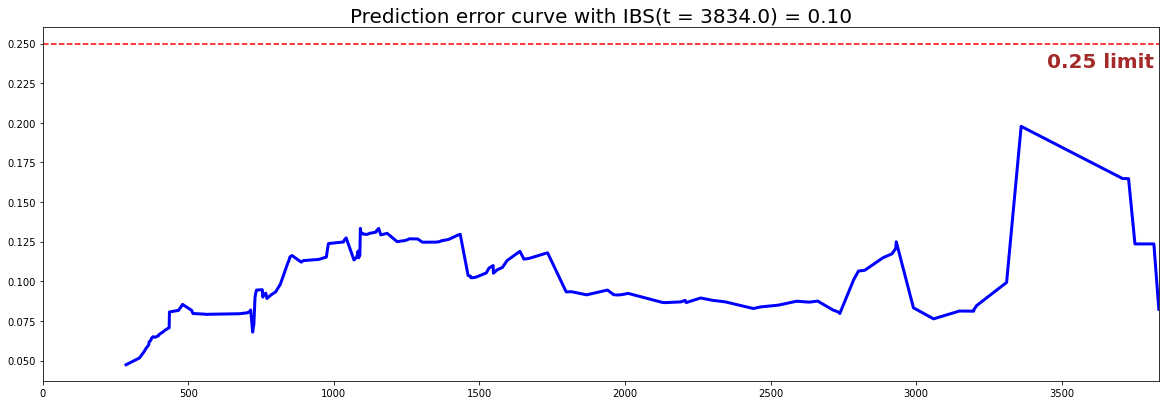

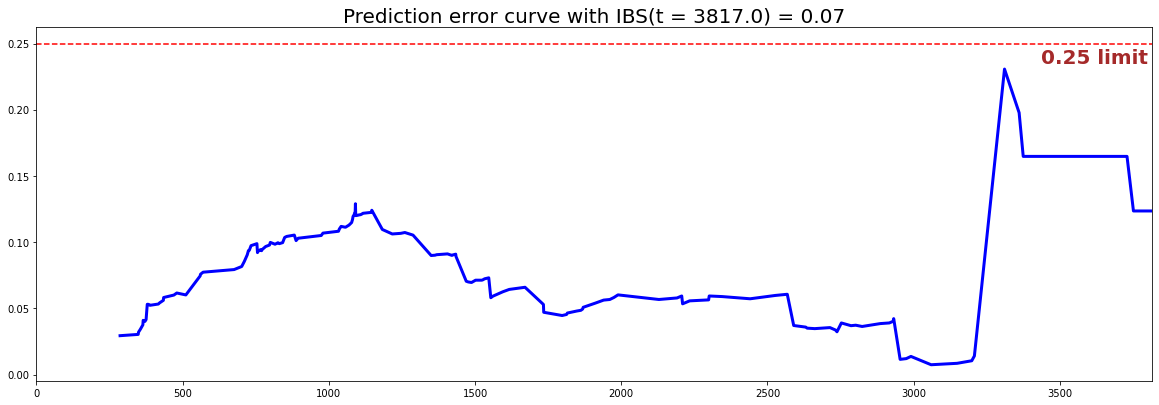

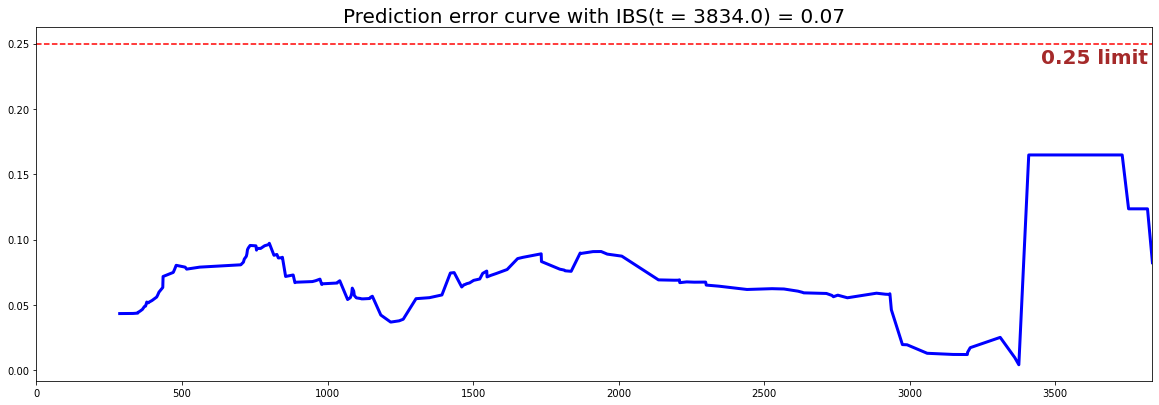

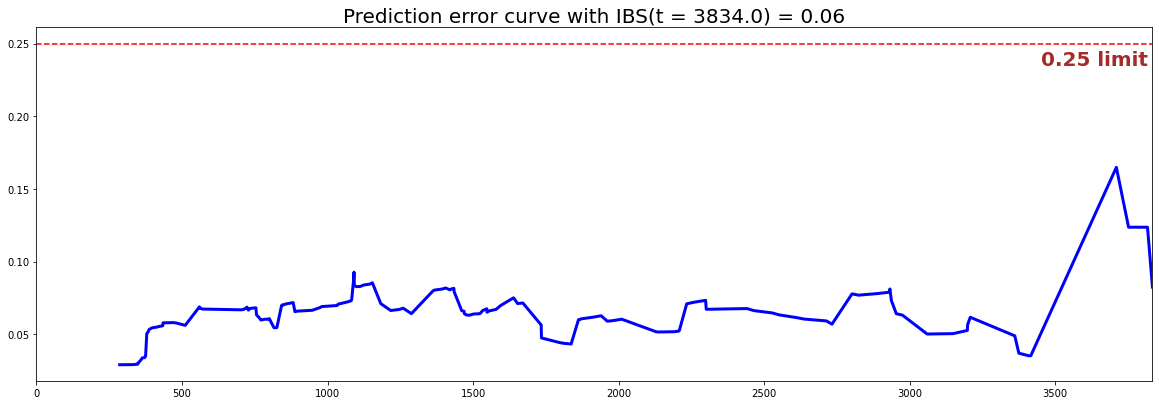

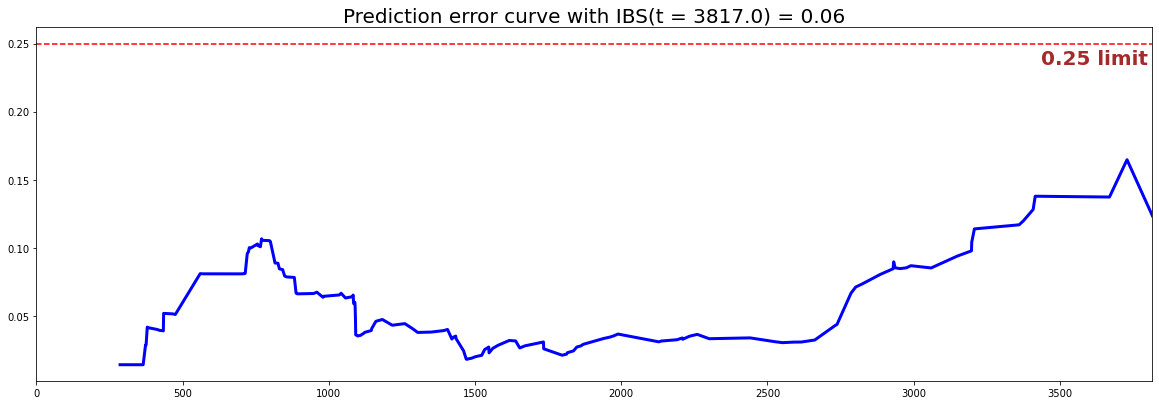

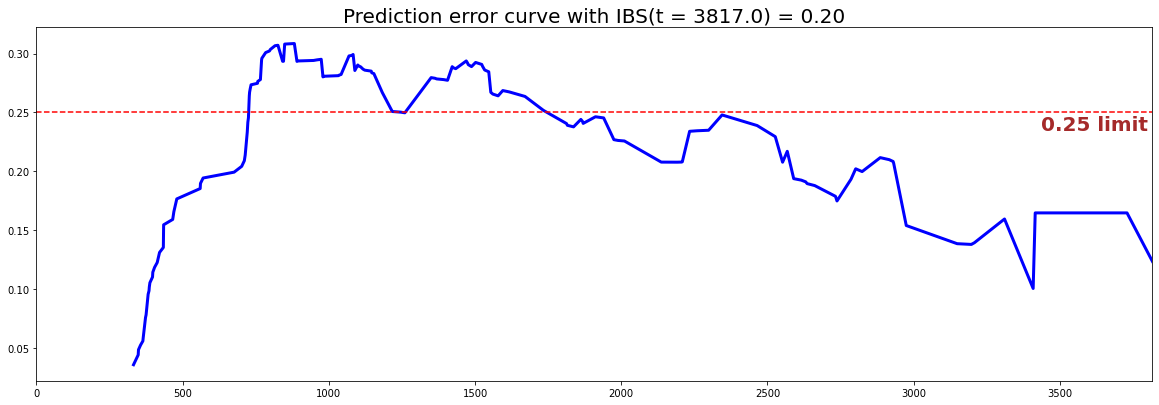

In [7]:
Loss_list=[]
C_index_list=[]
IBS_list=[]

for seed_i in np.arange(seed_num):
    model_used=models[seed_i]
    Loss_list.append(model_used.loss_values)
    
    # Model Performances
    c_index = concordance_index(model_used, X_test, time_test, event_test) #0.81
    #print('C-index: {:.2f}'.format(c_index))

    ibs = integrated_brier_score(model_used, X_test, time_test, event_test, t_max=None, figure_size=(20, 6.5) )
    #print('IBS: {:.2f}'.format(ibs))

    C_index_list.append(c_index)
    IBS_list.append(ibs)

In [8]:
p_path="./performance_CI.csv"
write_to_csv(np.array(C_index_list).reshape(1,np.array(C_index_list).shape[0]),p_path)
print(C_index_list)
print(np.mean(C_index_list))
print(np.std(C_index_list))

p_path="./performance_IBS.csv"
write_to_csv(np.array(IBS_list).reshape(1,np.array(IBS_list).shape[0]),p_path)
print(IBS_list)
print(np.mean(IBS_list))
print(np.std(IBS_list))

[0.9328324047189361, 0.9428696493653829, 0.901551064013305, 0.8643619366776732, 0.9272618841171243, 0.9048667100006603, 0.8506411422002198, 0.9225382978413621, 0.9148905238760783, 0.8373575229049913, 0.8967725653652279, 0.9111167018152009, 0.9003556287154404, 0.9046316161767026, 0.6612377374642215]
0.8848856923501686
0.06622264710548856
[0.03900248983669114, 0.04662242972350997, 0.050405161713294414, 0.08406967977470531, 0.057038233672511596, 0.06162632432377813, 0.09379856065851958, 0.057900298527610805, 0.061960567234016106, 0.09901395952925801, 0.07331472989660914, 0.06733665195020527, 0.06271893943490277, 0.059719662450342874, 0.195233439367251]
0.07398407520621375
0.03611898298179841


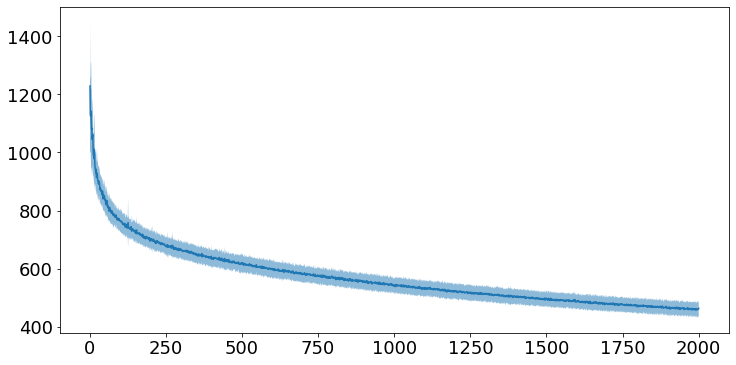

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
Loss_list_mean=np.mean(np.array(Loss_list),axis=0)
Loss_list_std=np.std(np.array(Loss_list),axis=0)

max_loss=int(np.max(Loss_list_mean))+1
min_loss=int(np.min(Loss_list_mean))
step=int(max_loss/5)

ax.plot(np.arange(epoch_num)+1, Loss_list_mean, '-')
ax.fill_between(np.arange(epoch_num)+1, Loss_list_mean - Loss_list_std, Loss_list_mean + Loss_list_std, alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

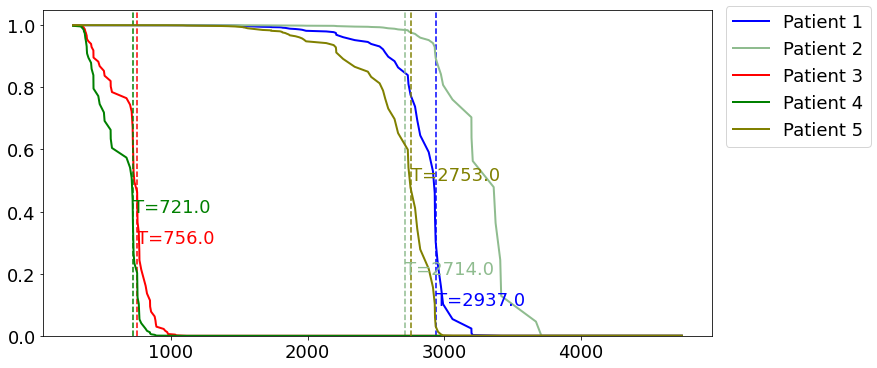

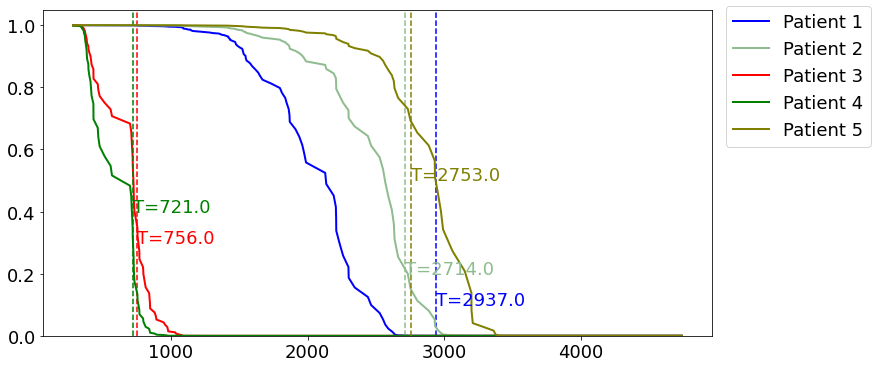

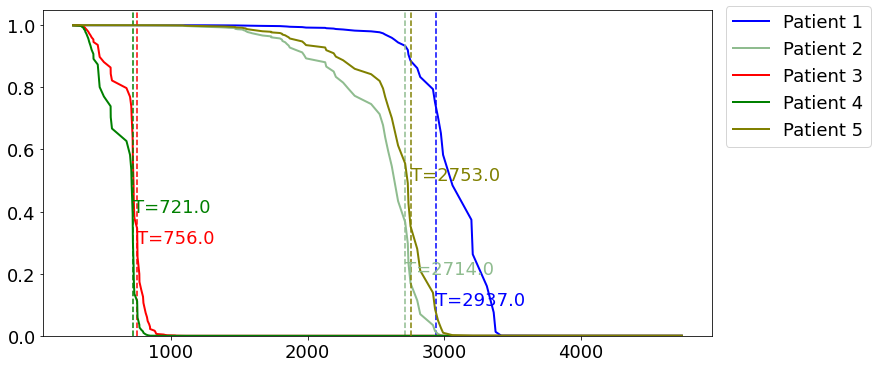

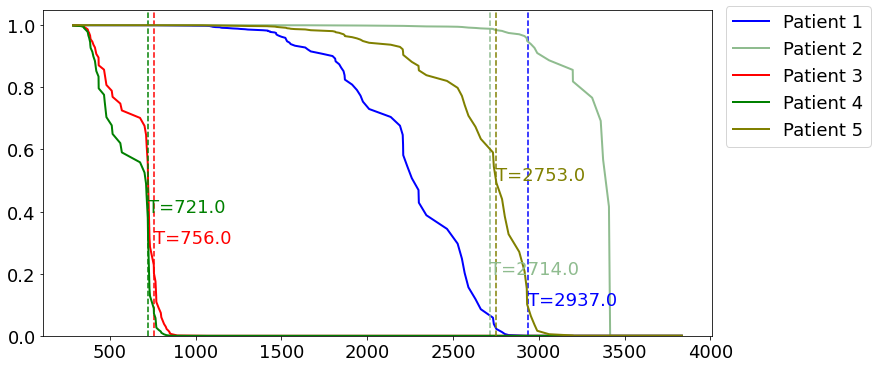

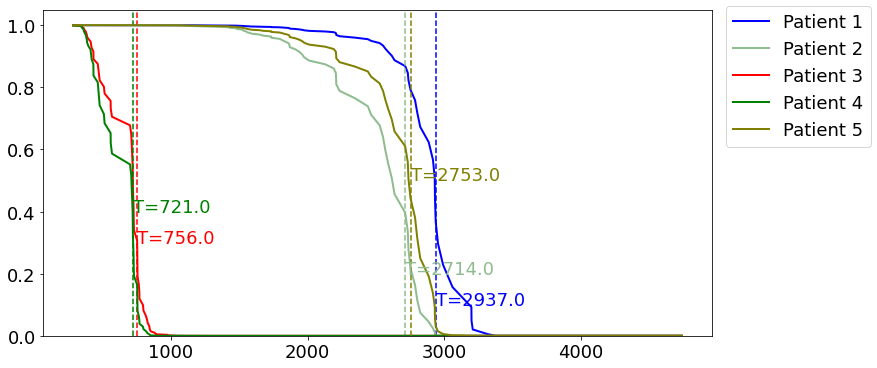

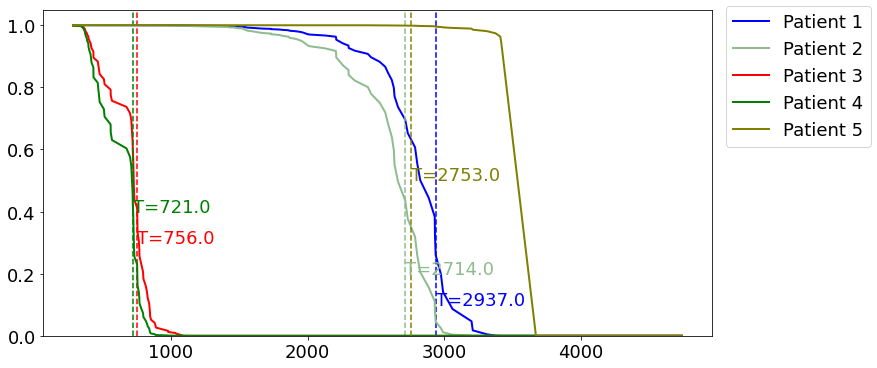

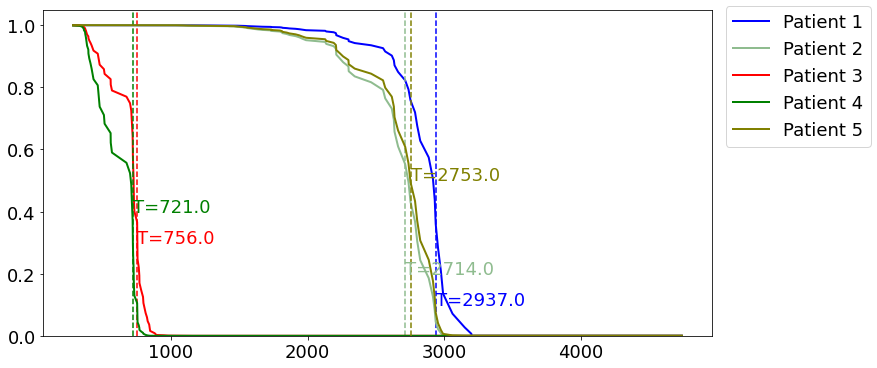

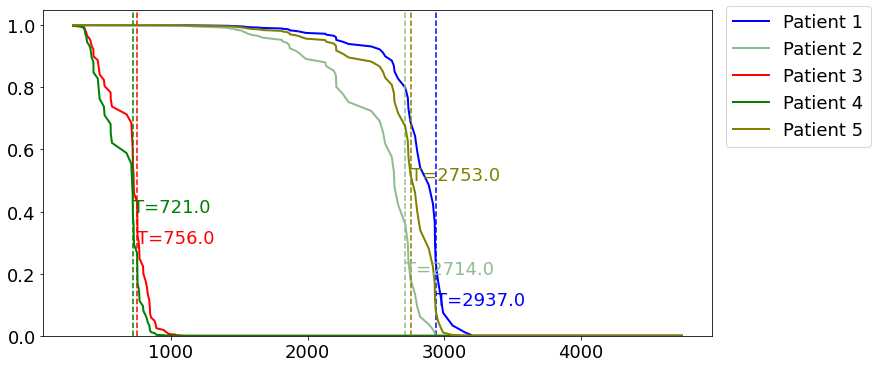

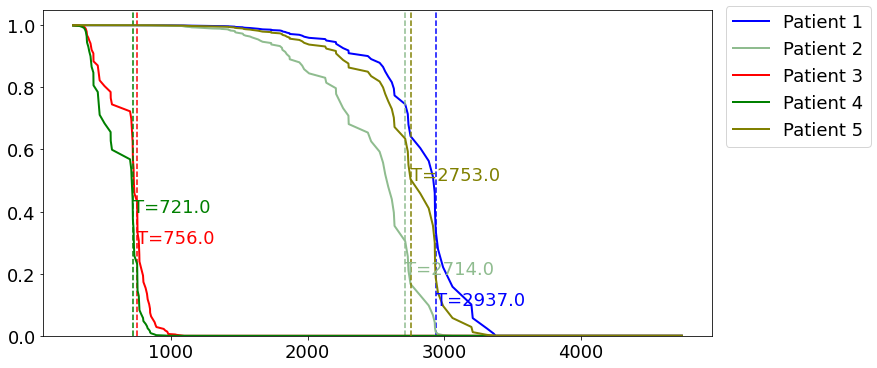

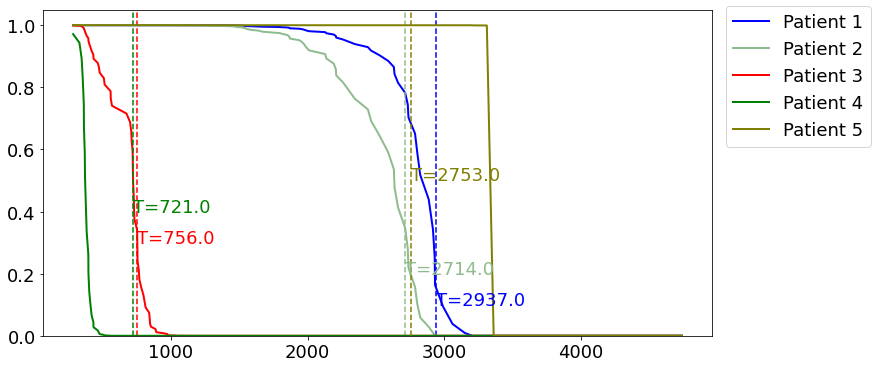

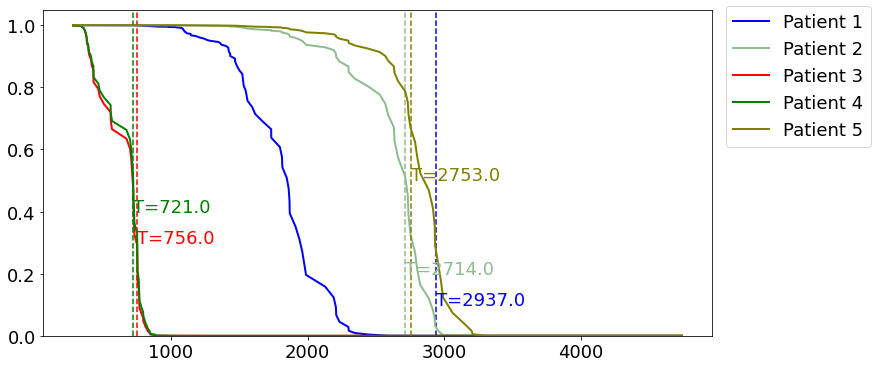

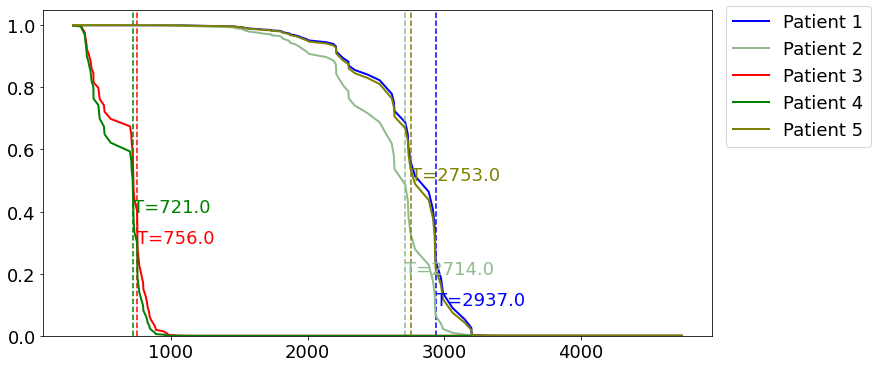

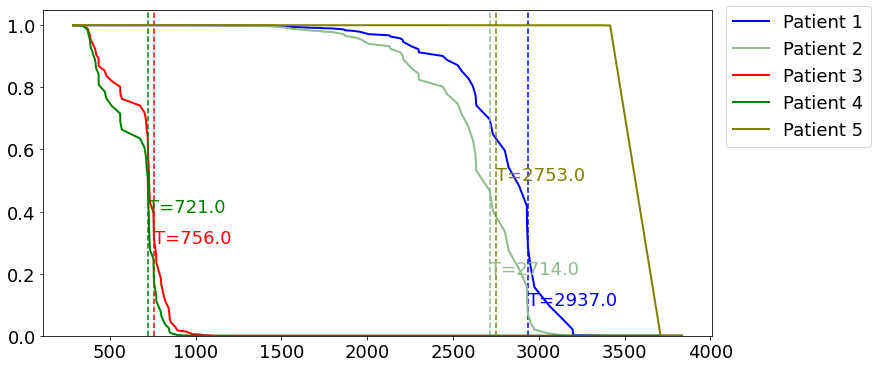

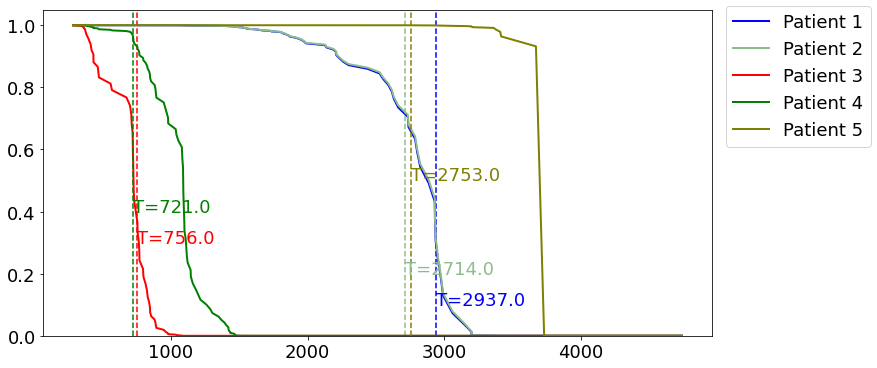

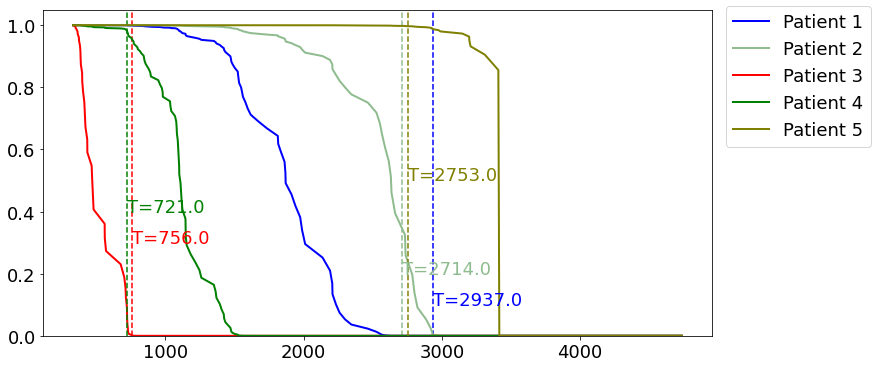

In [10]:
cs=['blue','darkseagreen','red','green','olive','cyan','tan','silver','purple','fuchsia','chocolate','darkcyan','aqua','pink','orange','bisque','lightsteelblue']

# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k_list = np.random.choice( choices, 5,replace=False)

for seed_i in np.arange(seed_num):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Saving the time of event
    for i in np.arange(len(k_list)):
        k=k_list[i]
        t = time_test[k]

        # Computing the Survival function for all times t
        predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()

        # Displaying the functions
        plt.plot(models[seed_i].times, predicted, color=cs[i], label='Patient '+str(i+1), lw=2)
    
        # Actual time
        plt.axvline(x=t, color=cs[i], ls ='--')
        ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, (0.1+i/10)), fontsize=18,color=cs[i])

    plt.legend(loc=[1.02,0.58],fontsize=18, ncol=1)
    plt.ylim(0, 1.05)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

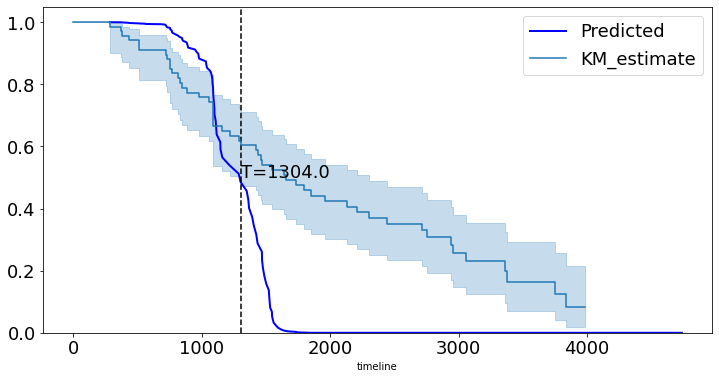

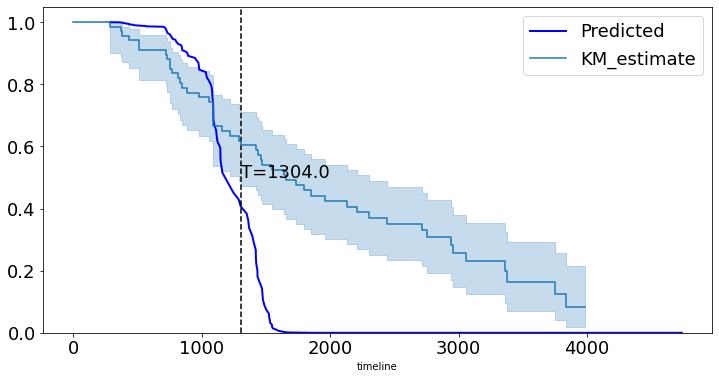

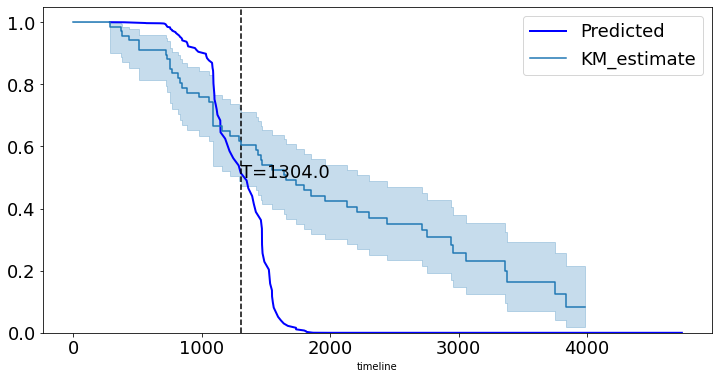

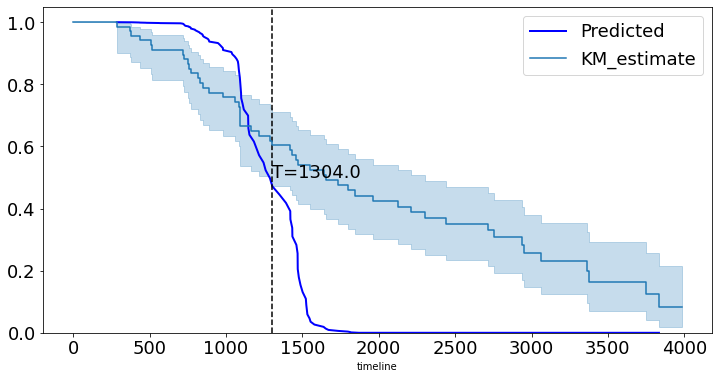

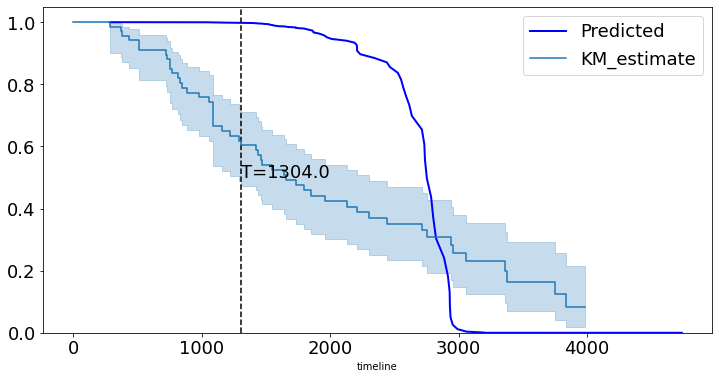

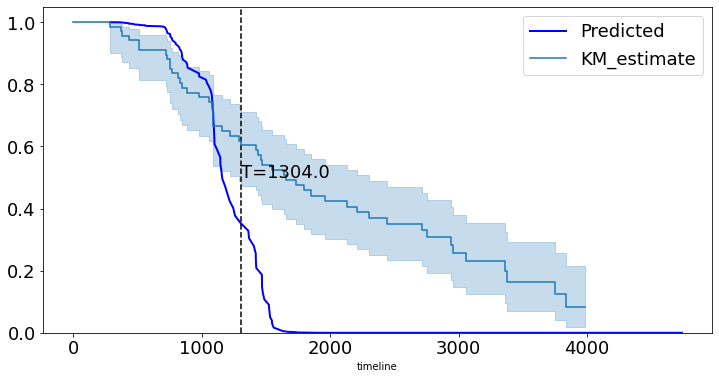

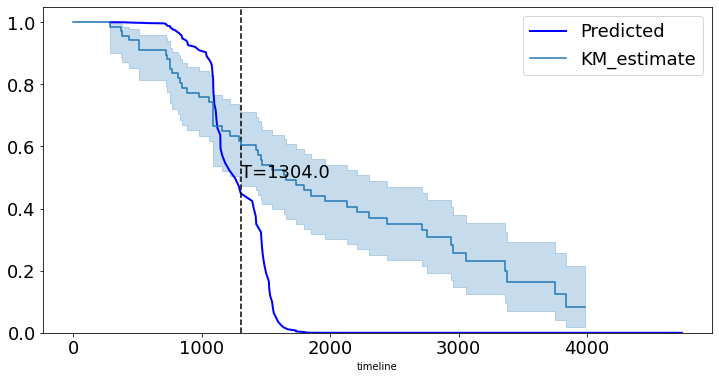

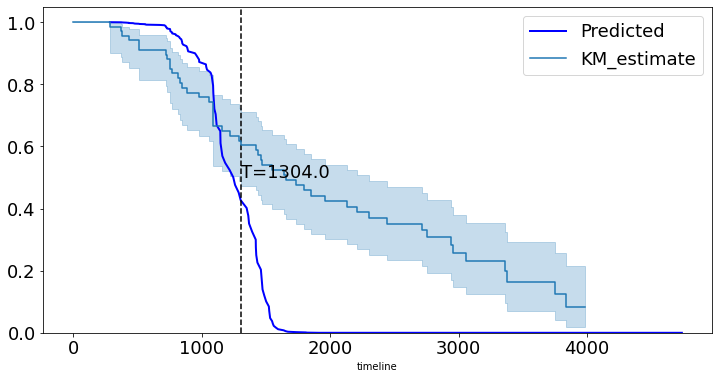

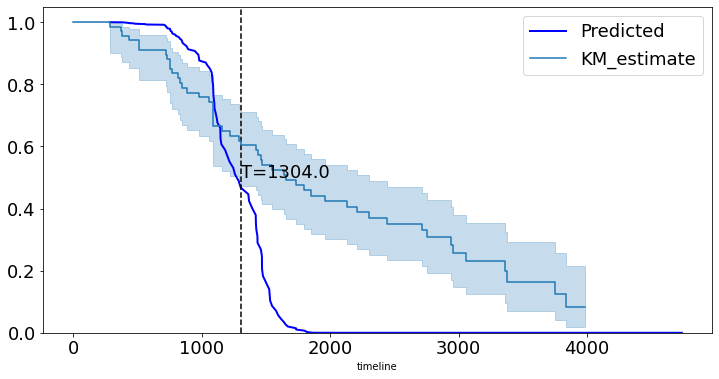

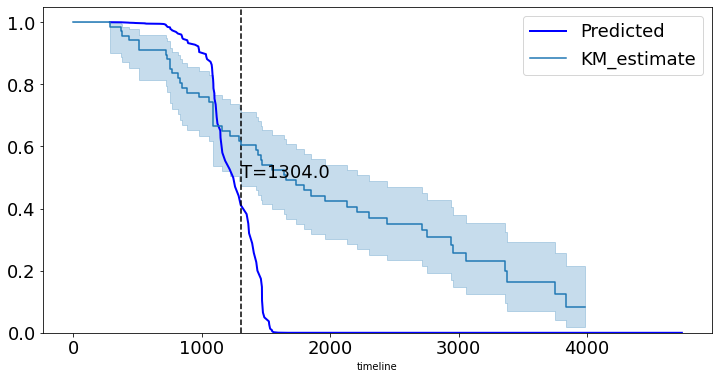

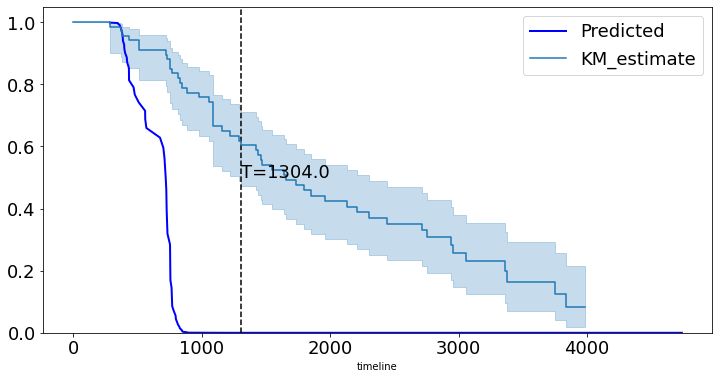

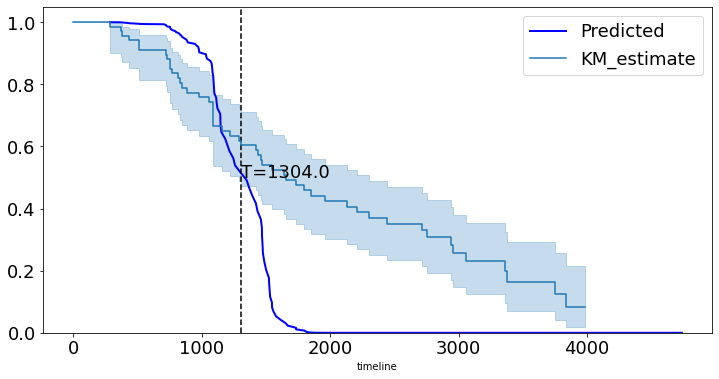

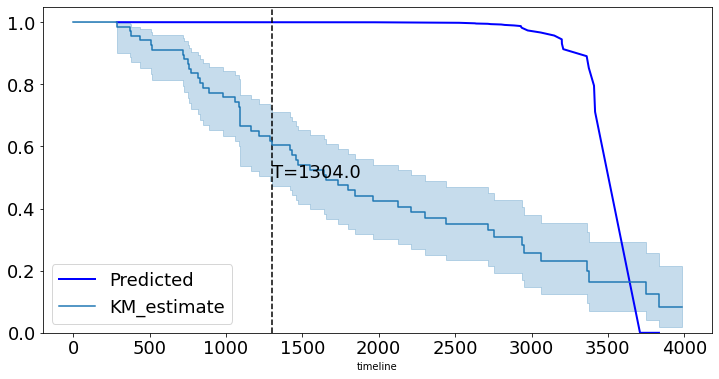

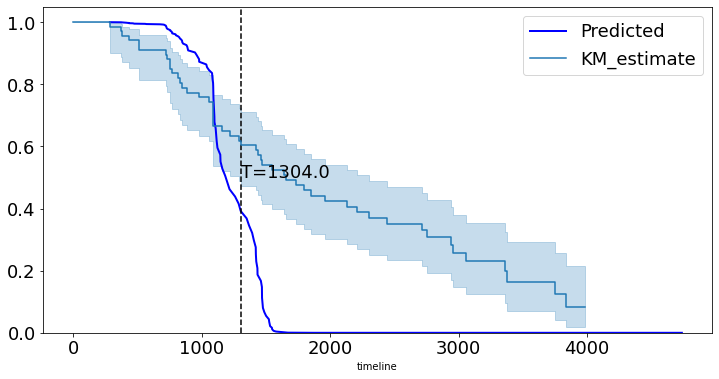

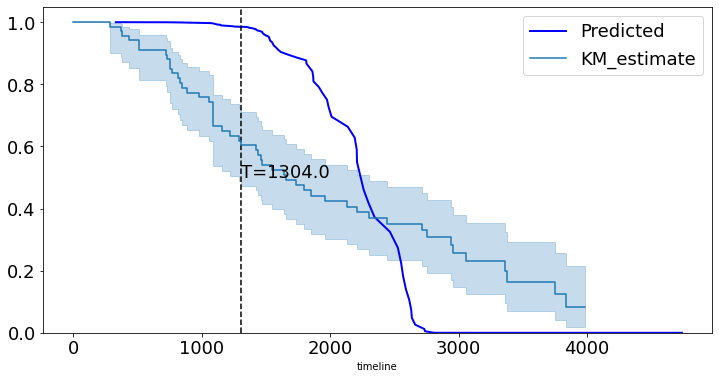

In [11]:
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice( choices, 1)[0]
    
for seed_i in np.arange(seed_num):
    
    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(12, 6))

    # Saving the time of event
    t = time_test[k]

    # Computing the Survival function for all times t
    predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()

    # Displaying the functions
    plt.plot(models[seed_i].times, predicted, color='blue', label='Predicted', lw=2)

    # Actual time
    plt.axvline(x=t, color='black', ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

    kmf.fit(time_test, event_observed=event_test)
    ax = kmf.plot_survival_function(ax=ax)

    # Show everything
    plt.legend(fontsize=18)
    plt.ylim(0, 1.05)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

In [12]:
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice(choices, 1)[0]

# Saving the time of event
t = time_test[k]

predicted_list=[]
time_set={'Nan'}

for seed_i in np.arange(seed_num):
    # Computing the Survival function for all times t
    predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()
    time=models[seed_i].times

    predicted_list.append(dict(zip(time,predicted)))
    time_set.update(set(time))

average_time_predicted_dict={}
for time_set_i in time_set:
    predicted_value=[]
    for seed_i in np.arange(seed_num):
        if time_set_i in predicted_list[seed_i].keys():
            predicted_value.append(predicted_list[seed_i][time_set_i])
    if len(predicted_value)>0:
        average_time_predicted_dict[time_set_i]=[np.mean(predicted_value),np.std(predicted_value)]
        
average_time_predicted={}
for i in sorted (average_time_predicted_dict.keys()) : 
    average_time_predicted[i]=average_time_predicted_dict[i]

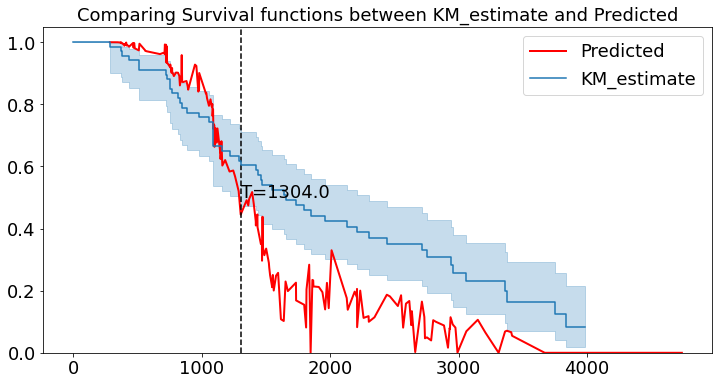

In [13]:
kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(12, 6))

# Displaying the functions
plt.plot(list(average_time_predicted.keys()), np.array(list(average_time_predicted.values()))[:,0], color='red', label='Predicted', lw=2)

# Actual time
plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

kmf.fit(time_test, event_observed=event_test)
ax = kmf.plot_survival_function(ax=ax)

# Show everything
title = "Comparing Survival functions between KM_estimate and Predicted"
plt.legend(fontsize=18)
plt.title(title, fontsize=18)
plt.ylim(0, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("",fontsize=18)
plt.show()

In [14]:
models[0].model

NeuralNet(
  (model): Sequential(
    (0): Linear(in_features=324, out_features=150, bias=True)
    (1): BentIdentity()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=150, out_features=1, bias=True)
  )
)

In [15]:
feature_importace_list=[]
first_layer_weight_list=[]
for seed_i in np.arange(seed_num):
    first_layer_weight_=np.array(np.transpose(models[seed_i].model.state_dict()['model.0.weight']))
    feature_importace_=np.linalg.norm(first_layer_weight_,1, axis=1)
    first_layer_weight_list.append(first_layer_weight_)
    feature_importace_list.append(feature_importace_)

In [16]:
feature_importace=np.mean(np.array(feature_importace_list),axis=0)

In [17]:
column_names

['NACCREAS',
 'NACCREFR',
 'BIRTHMO',
 'BIRTHYR',
 'SEX',
 'HISPANIC',
 'HISPOR',
 'RACE',
 'RACESEC',
 'RACETER',
 'PRIMLANG',
 'EDUC',
 'MARISTAT',
 'NACCLIVS',
 'INDEPEND',
 'RESIDENC',
 'HANDED',
 'INBIRMO',
 'INBIRYR',
 'INSEX',
 'NACCNINR',
 'INRELTO',
 'INLIVWTH',
 'INVISITS',
 'INCALLS',
 'INRELY',
 'NACCFAM',
 'NACCMOM',
 'NACCDAD',
 'NACCFADM',
 'NACCFFTD',
 'ANYMEDS',
 'DRUG1',
 'NACCSTYR',
 'NACCTIYR',
 'MEMORY',
 'ORIENT',
 'JUDGMENT',
 'COMMUN',
 'HOMEHOBB',
 'PERSCARE',
 'CDRSUM',
 'COMPORT',
 'CDRLANG',
 'NPIQINF',
 'DEL',
 'DELSEV',
 'HALL',
 'HALLSEV',
 'AGIT',
 'AGITSEV',
 'DEPD',
 'DEPDSEV',
 'ANX',
 'ANXSEV',
 'ELAT',
 'ELATSEV',
 'APA',
 'APASEV',
 'DISN',
 'DISNSEV',
 'IRR',
 'IRRSEV',
 'MOT',
 'MOTSEV',
 'NITE',
 'NITESEV',
 'APP',
 'APPSEV',
 'BILLS',
 'TAXES',
 'SHOPPING',
 'GAMES',
 'STOVE',
 'MEALPREP',
 'EVENTS',
 'PAYATTN',
 'REMDATES',
 'TRAVEL',
 'DECSUB',
 'DECIN',
 'COGMEM',
 'COGJUDG',
 'COGLANG',
 'COGVIS',
 'COGATTN',
 'COGFLUC',
 'COGOTHR',
 'NACCC

In [18]:
k=100
p_path="./feature_selection.csv"

top_k=heapq.nlargest(k, range(len(feature_importace)), feature_importace.take)

In [19]:
write_to_csv(np.array(top_k).reshape(1,np.array(top_k).shape[0]),p_path)

top_k

[164,
 38,
 167,
 168,
 122,
 36,
 192,
 170,
 114,
 41,
 88,
 11,
 255,
 314,
 295,
 188,
 39,
 206,
 87,
 70,
 28,
 71,
 104,
 75,
 1,
 315,
 322,
 93,
 272,
 0,
 27,
 15,
 65,
 73,
 108,
 78,
 84,
 43,
 14,
 226,
 209,
 4,
 186,
 175,
 317,
 44,
 16,
 66,
 107,
 200,
 18,
 94,
 52,
 171,
 211,
 98,
 173,
 50,
 85,
 177,
 54,
 169,
 172,
 116,
 74,
 181,
 191,
 58,
 313,
 32,
 213,
 208,
 6,
 235,
 92,
 216,
 80,
 106,
 183,
 227,
 56,
 277,
 165,
 111,
 60,
 79,
 296,
 57,
 19,
 109,
 176,
 273,
 199,
 46,
 23,
 24,
 146,
 270,
 256,
 195]

In [20]:
write_to_csv(feature_importace[top_k].reshape(1,feature_importace[top_k].shape[0]),p_path)

feature_importace[top_k]

array([14.1158905, 12.227532 , 12.061395 , 11.568512 , 10.9111395,
       10.584028 , 10.218    ,  9.8856   ,  9.769367 ,  9.740207 ,
        9.455488 ,  9.375627 ,  9.365019 ,  9.363819 ,  9.347098 ,
        9.242197 ,  9.212646 ,  9.183886 ,  9.174211 ,  9.105851 ,
        9.102177 ,  9.092312 ,  9.090134 ,  9.082783 ,  9.036746 ,
        9.021246 ,  9.017538 ,  9.016854 ,  8.993354 ,  8.958106 ,
        8.949185 ,  8.943978 ,  8.939371 ,  8.936395 ,  8.92167  ,
        8.915858 ,  8.902501 ,  8.894216 ,  8.892822 ,  8.880473 ,
        8.879405 ,  8.862695 ,  8.857197 ,  8.846957 ,  8.837814 ,
        8.831665 ,  8.828204 ,  8.824077 ,  8.811098 ,  8.809835 ,
        8.794509 ,  8.787764 ,  8.782103 ,  8.776859 ,  8.773847 ,
        8.771361 ,  8.767226 ,  8.763757 ,  8.756594 ,  8.750688 ,
        8.746701 ,  8.725842 ,  8.725804 ,  8.710844 ,  8.708852 ,
        8.708527 ,  8.704232 ,  8.70389  ,  8.702851 ,  8.695314 ,
        8.694223 ,  8.693574 ,  8.692376 ,  8.692171 ,  8.6799

In [21]:
write_to_csv(np.array(column_names[:-2])[top_k].reshape(1,np.array(column_names[:-2])[top_k].shape[0]),p_path)

np.array(column_names[:-2])[top_k]

array(['NACCAGEB', 'COMMUN', 'NACCIDEM', 'NACCAGE', 'NACCMCII', 'ORIENT',
       'NACCNE4S', 'NACCAANX', 'NACCPPA', 'CDRSUM', 'NACCCOGF', 'EDUC',
       'NPWMR', 'NACCOTHP', 'NPTDPD', 'NACCPDMD', 'HOMEHOBB', 'NPASAN',
       'COGOTHR', 'TAXES', 'NACCDAD', 'SHOPPING', 'MOGAIT', 'EVENTS',
       'NACCREFR', 'NACCBNKF', 'NACCDAGE', 'BEVHALL', 'NPHIPSCL',
       'NACCREAS', 'NACCMOM', 'RESIDENC', 'NITE', 'STOVE', 'NACCMOTF',
       'TRAVEL', 'COGVIS', 'CDRLANG', 'INDEPEND', 'NPINF2B', 'NPHISG',
       'SEX', 'NACCLIPL', 'NACCAHTN', 'NACCFORM', 'NPIQINF', 'HANDED',
       'NITESEV', 'MOSLOW', 'NPGRHA', 'INBIRYR', 'BEAHALL', 'DEPDSEV',
       'NACCAC', 'NPHIST', 'BEAGIT', 'NACCADEP', 'AGITSEV', 'COGATTN',
       'NACCANGI', 'ANXSEV', 'NACCAAAS', 'NACCACEI', 'NACCLBDS',
       'MEALPREP', 'NACCDBMD', 'NACCAPOE', 'APASEV', 'NPPDXQ', 'DRUG1',
       'NPTHAL', 'NPHISMB', 'HISPOR', 'NPINF4D', 'BEDEP', 'NPADNC',
       'DECIN', 'MOTREM', 'NACCEMD', 'NPINF2D', 'ELATSEV', 'NACCPROG',
       'NACCNIH

In [22]:
np.array(column_names[:-2]).shape

(324,)

In [23]:
first_layer_weight=np.mean(np.array(first_layer_weight_list),axis=0)

In [24]:
first_layer_weight.shape

(324, 150)

In [25]:
first_layer_weight

array([[ 0.01233329, -0.00061603,  0.01600872, ..., -0.02220876,
        -0.01637454,  0.03154658],
       [ 0.02335844,  0.02694061,  0.02913092, ..., -0.01122659,
        -0.00270919,  0.01145938],
       [-0.00110189, -0.0154251 ,  0.03036316, ..., -0.01573726,
         0.00275051,  0.00609531],
       ...,
       [ 0.02187398,  0.00549825, -0.00492097, ...,  0.01504311,
         0.01717664, -0.01334663],
       [ 0.00812306,  0.01215282, -0.04602145, ...,  0.05779654,
         0.00053024,  0.01544424],
       [-0.01342151,  0.00664262,  0.02204809, ..., -0.01926534,
         0.00797848, -0.00357035]], dtype=float32)

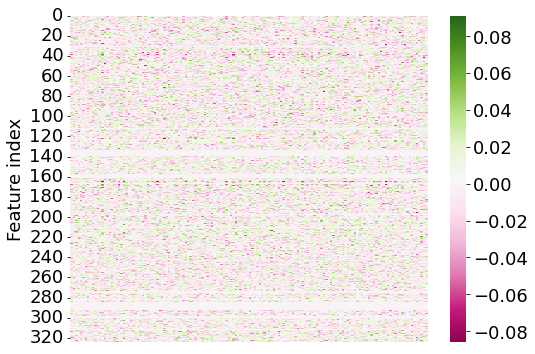

In [26]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight, cmap='PiYG')
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()

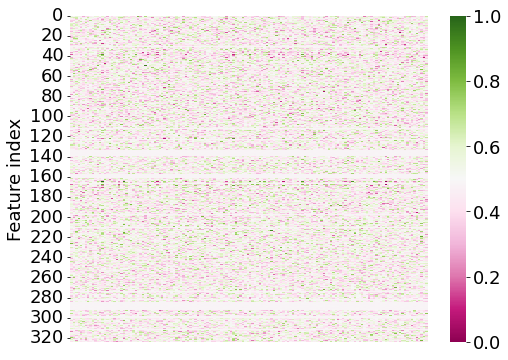

In [27]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()
first_layer_weight_scaled = (first_layer_weight - mn) / (mx - mn)

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight_scaled, cmap='PiYG', vmin=0, vmax=1)
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()